### Installing Dependencies

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Cropping the column with the required shapes

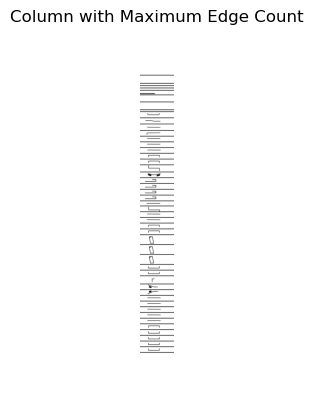

In [2]:
# Read the image using OpenCV
img_path = "upscaled1.png"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# Apply Gaussian blur to reduce noise
blurred_img = cv2.GaussianBlur(img, (5, 5), 0)

# Apply Canny edge detection
edges = cv2.Canny(blurred_img, 50, 150, apertureSize=3)

# Detect lines using probabilistic Hough transform
lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=100, minLineLength=100, maxLineGap=10)

# Draw lines on a copy of the original image
lines_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
vertical_lines = []
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        if abs(x1 - x2) < abs(y1 - y2):
            cv2.line(lines_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            vertical_lines.append((x1 + x2) // 2)

# Sort vertical line x-coordinates
vertical_lines.sort()

# Iterate over pairs of vertical lines to find data between them
for i in range(len(vertical_lines) - 1):
    x1 = vertical_lines[i]
    x2 = vertical_lines[i + 1]

    # Crop the column between two vertical lines
    column_img = img[:, x1:x2]

    # Calculate the Canny edge count for the column
    edge_count = np.sum(edges[:, x1:x2] == 255)

    # Check if this column has the maximum edge count
    max_edge_count = max(np.sum(edges[:, vertical_lines[i]:vertical_lines[i + 1]] == 255) for i in range(len(vertical_lines) - 1))
    if edge_count == max_edge_count:
        # Display the cropped column
        plt.imshow(column_img, cmap='gray')
        plt.axis('off')
        plt.title("Column with Maximum Edge Count")
        plt.show()
        cv2.imwrite(f"cropped_column.png", column_img)


## Cropping rows to store every image separately in a separate folder

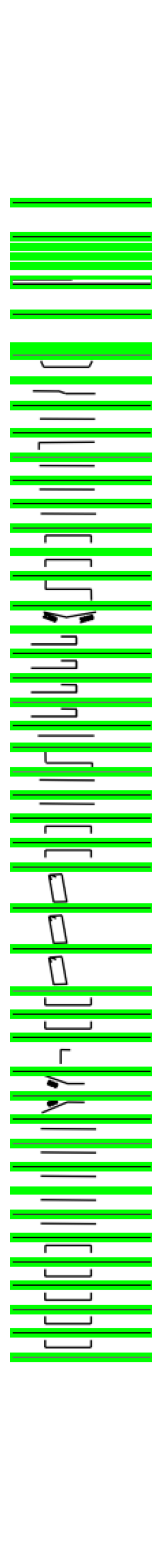

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read the cropped column image
cropped_column_img = cv2.imread("cropped_column.png", cv2.IMREAD_GRAYSCALE)

# Apply Gaussian blur to reduce noise
blurred_img = cv2.GaussianBlur(cropped_column_img, (5, 5), 0)

# Apply adaptive thresholding to binarize the image
binary_image_adaptive = cv2.adaptiveThreshold(blurred_img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 5)

# Apply morphological closing to connect nearby edges and smoothen the lines
kernel = np.ones((1, 5), np.uint8)
closed_img = cv2.morphologyEx(binary_image_adaptive, cv2.MORPH_CLOSE, kernel)

# Find horizontal lines using morphological operations
horizontal_lines = cv2.morphologyEx(closed_img, cv2.MORPH_OPEN, kernel, iterations=2)

# Find contours of horizontal lines
contours, _ = cv2.findContours(horizontal_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter horizontal lines based on length and horizontal coverage
filtered_lines = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    if w > 0.9 * cropped_column_img.shape[1]:  # Check if line spans entire width
        filtered_lines.append(contour)

# Draw the filtered horizontal lines on a copy of the original image
lines_img = cv2.cvtColor(cropped_column_img, cv2.COLOR_GRAY2BGR)
for line in filtered_lines:
    x, y, w, h = cv2.boundingRect(line)
    cv2.rectangle(lines_img, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Display the image with filtered horizontal lines
plt.figure(figsize=(20, 20))
plt.imshow(lines_img)
plt.axis('off')
plt.show()


In [4]:
import cv2
import numpy as np
import os

def is_image_blank(image, blank_threshold=0.98, min_non_blank_pixels=100):
    # Calculate the percentage of white pixels in the image
    white_pixels = np.sum(image >= 200)  # Assuming white pixels have intensity >= 200
    total_pixels = image.size
    white_ratio = white_pixels / total_pixels

    # Check if the image has a large enough percentage of white pixels to be considered blank
    if white_ratio > blank_threshold:
        # Check if there are enough non-blank pixels to avoid mistakenly removing data rows
        non_blank_pixels = total_pixels - white_pixels
        if non_blank_pixels < min_non_blank_pixels:
            return True  # Image is considered blank
    return False  # Image is not blank

# Read the cropped column image
cropped_column_img = cv2.imread("cropped_column.png", cv2.IMREAD_GRAYSCALE)

# Apply Gaussian blur to reduce noise
blurred_img = cv2.GaussianBlur(cropped_column_img, (5, 5), 0)

# Apply adaptive thresholding to binarize the image
binary_image_adaptive = cv2.adaptiveThreshold(blurred_img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 5)

# Apply morphological closing to connect nearby edges and smoothen the lines
kernel = np.ones((1, 5), np.uint8)
closed_img = cv2.morphologyEx(binary_image_adaptive, cv2.MORPH_CLOSE, kernel)

# Find horizontal lines using morphological operations
horizontal_lines = cv2.morphologyEx(closed_img, cv2.MORPH_OPEN, kernel, iterations=2)

# Find contours of horizontal lines
contours, _ = cv2.findContours(horizontal_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter horizontal lines based on length and horizontal coverage
filtered_lines = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    if w > 0.9 * cropped_column_img.shape[1]:  # Check if line spans entire width
        filtered_lines.append(contour)

# Sort filtered lines by y-coordinate
filtered_lines.sort(key=lambda c: cv2.boundingRect(c)[1])

# Define the output folder
output_folder = "Shapes"

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Function to crop and save rows
def crop_and_save_rows(lines):
    for i in range(len(lines) - 1):
        x1, y1, w1, h1 = cv2.boundingRect(lines[i])
        x2, y2, w2, h2 = cv2.boundingRect(lines[i + 1])

        # Crop the region between two horizontal lines
        row_img = cropped_column_img[y1 + h1 : y2, :]

        # Check if the cropped row has sufficient width and is not blank
        if row_img.shape[1] > 5 and not is_image_blank(row_img):
            # Save the cropped row image
            cv2.imwrite(os.path.join(output_folder, f"row_{i + 1}.png"), row_img)

# Crop and save rows
crop_and_save_rows(filtered_lines)

# Print the number of saved rows
num_rows_saved = len(os.listdir(output_folder))
print(f"{num_rows_saved} rows saved in the '{output_folder}' folder.")


45 rows saved in the 'Shapes' folder.


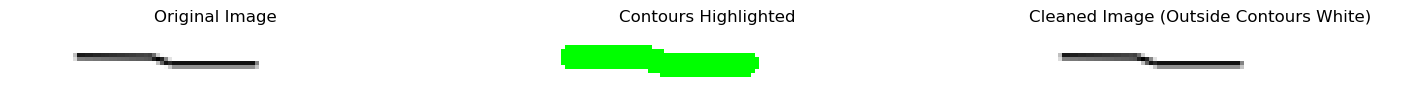

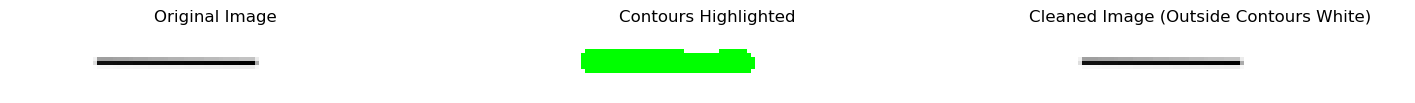

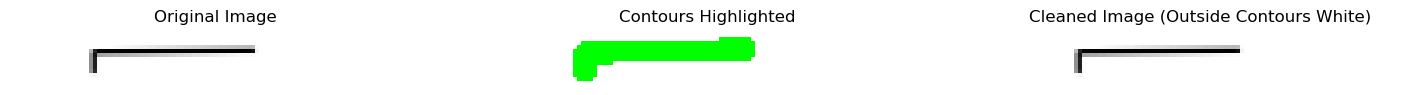

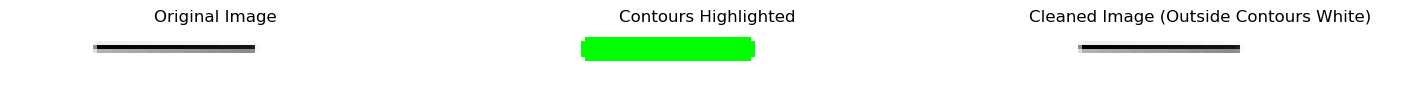

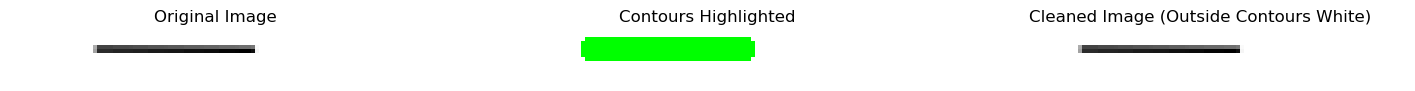

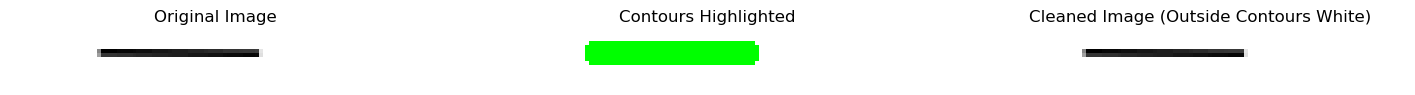

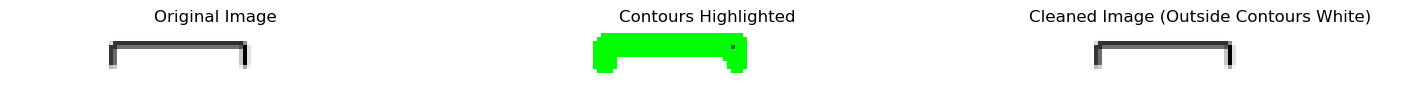

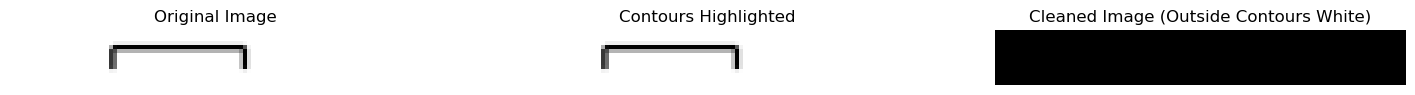

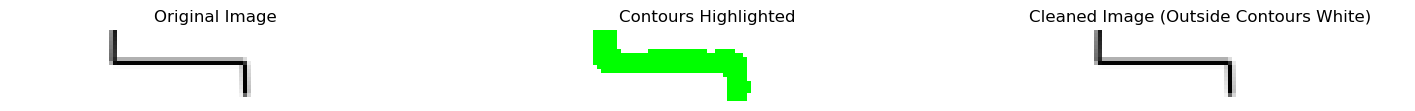

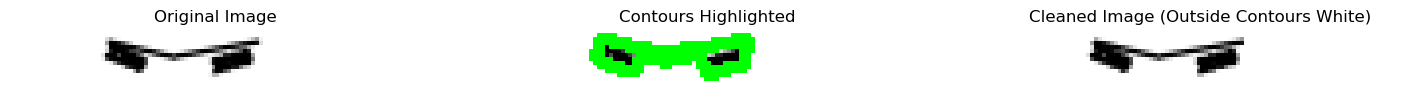

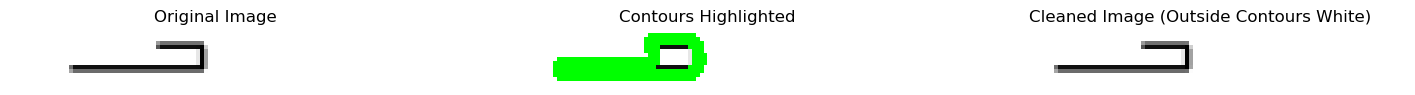

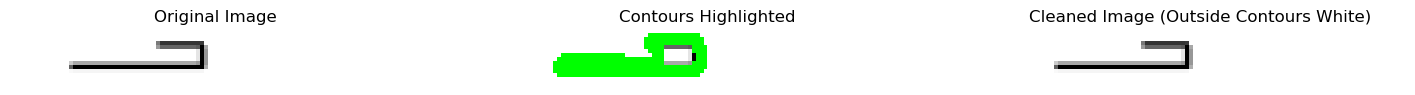

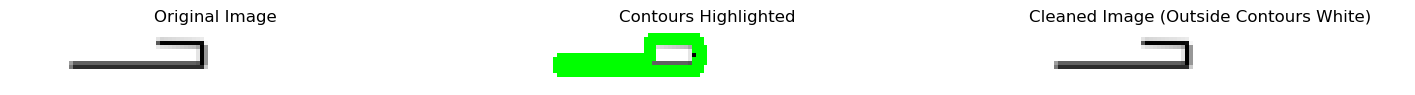

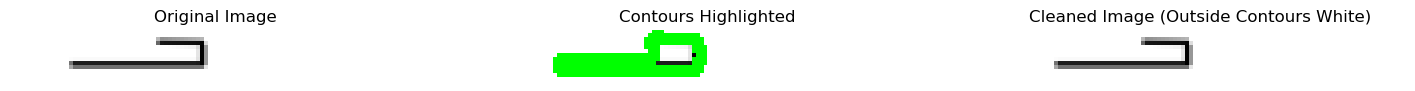

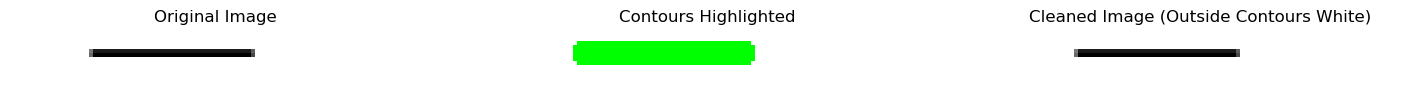

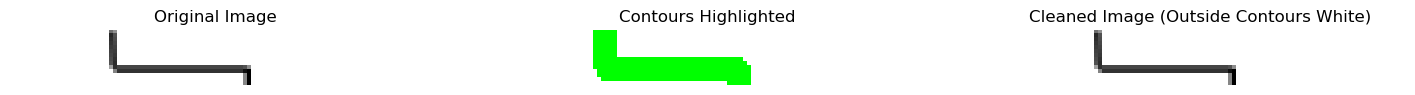

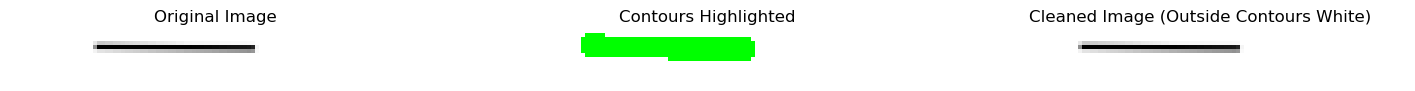

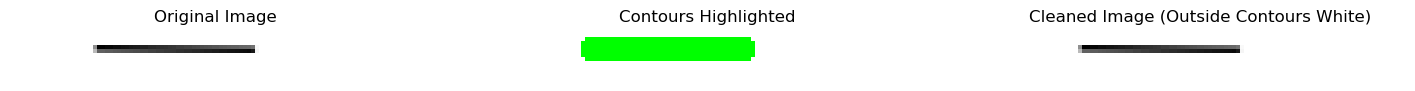

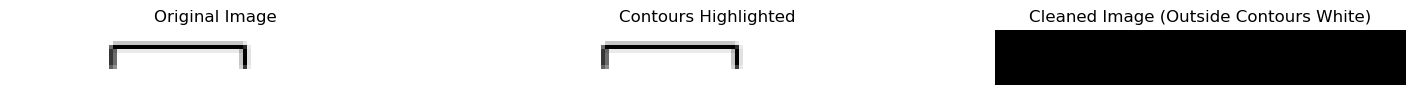

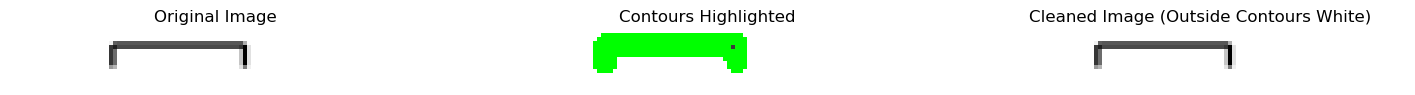

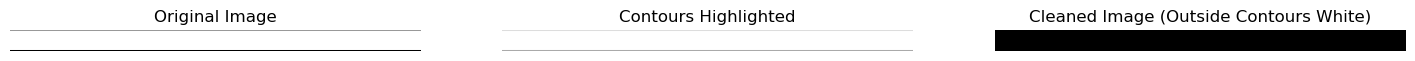

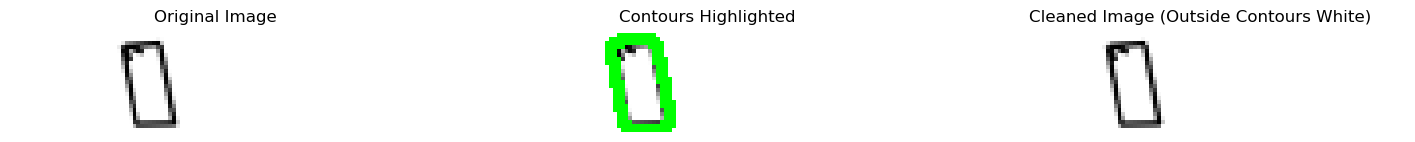

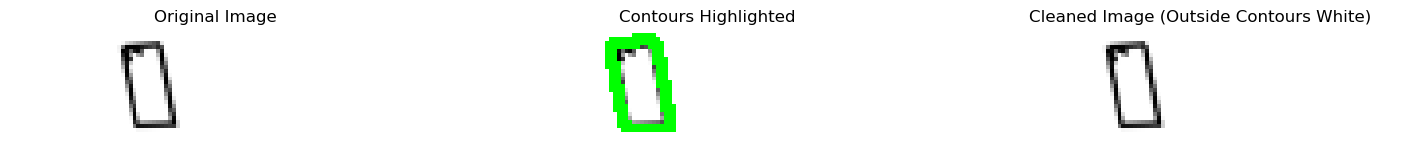

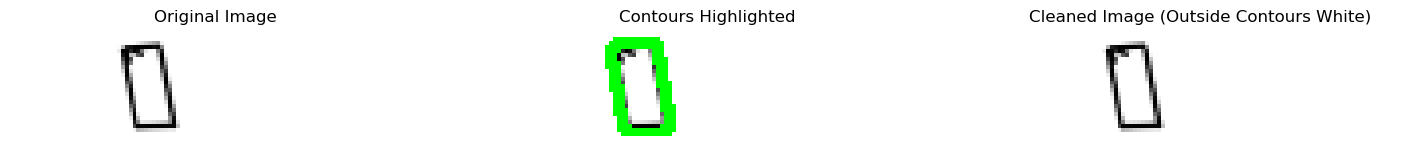

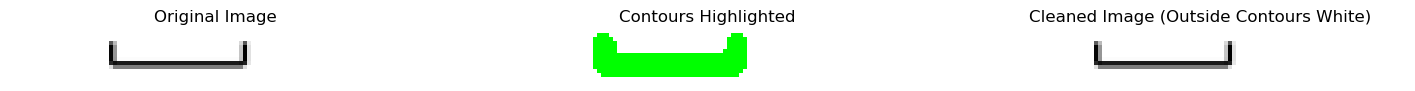

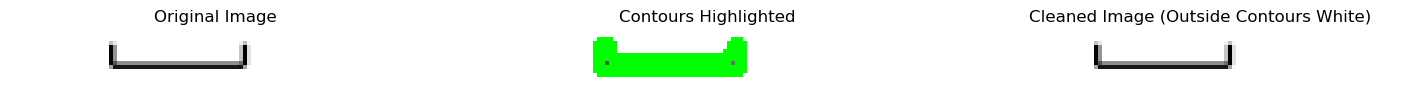

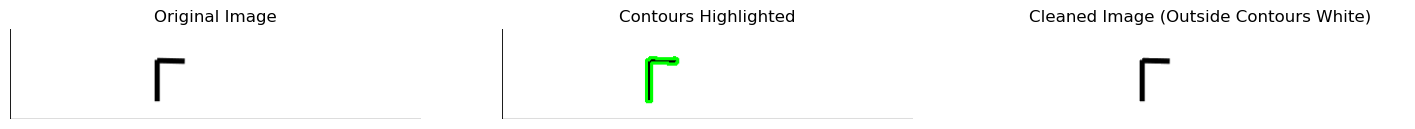

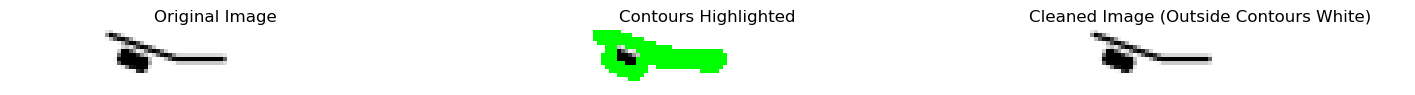

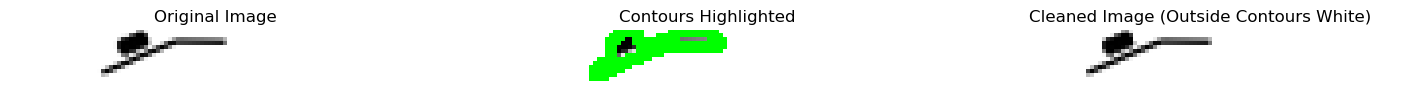

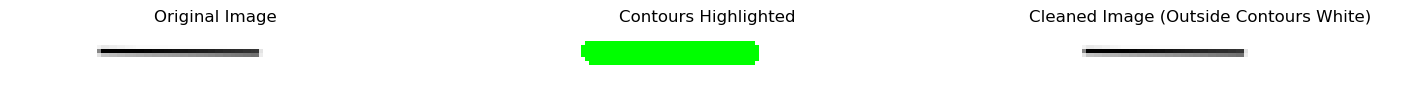

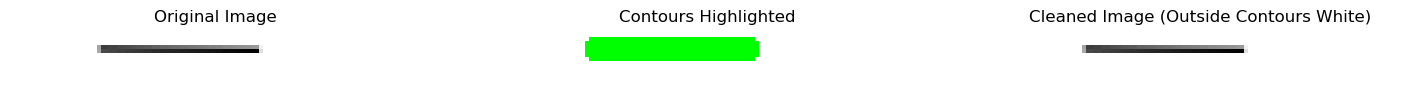

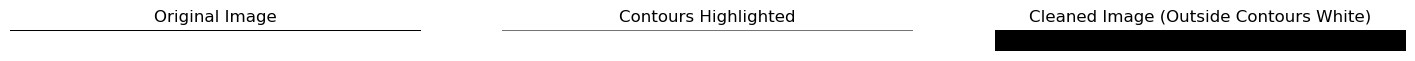

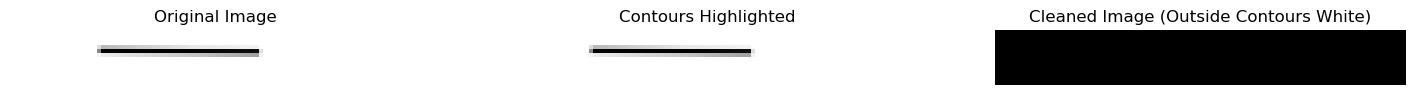

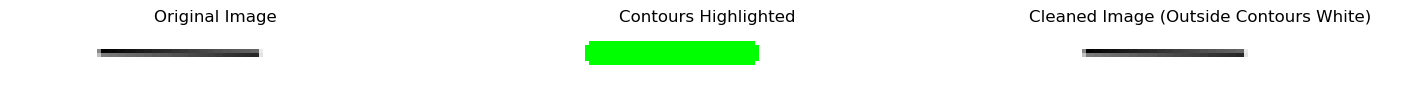

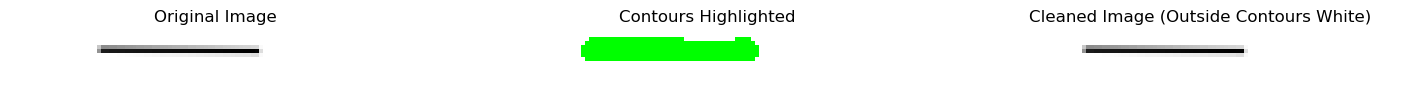

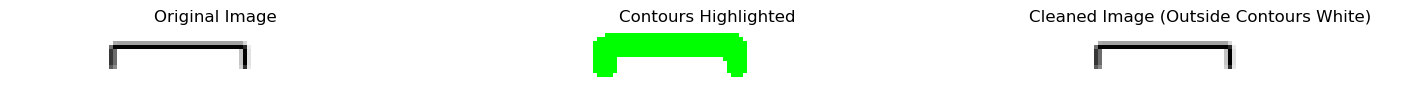

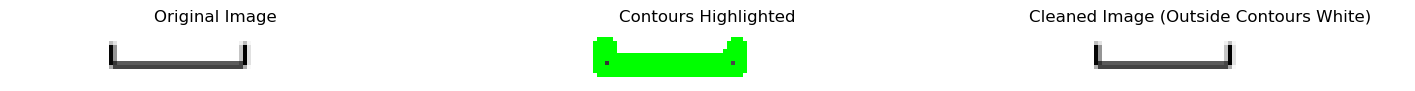

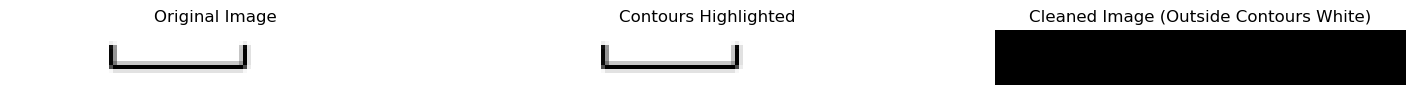

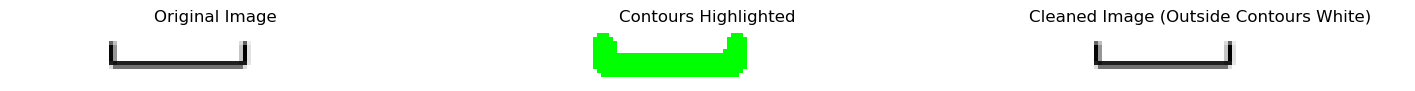

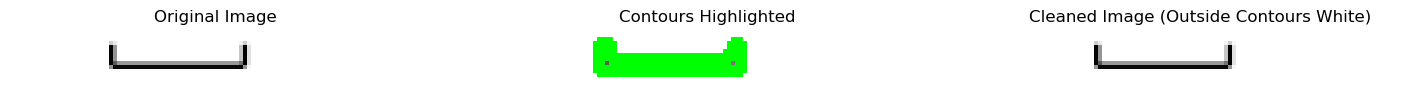

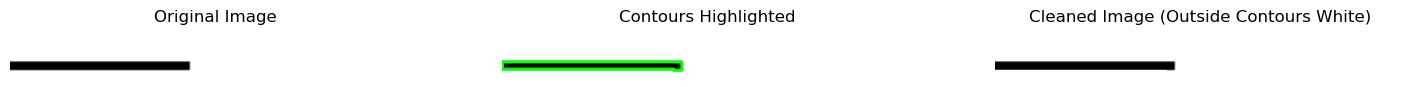

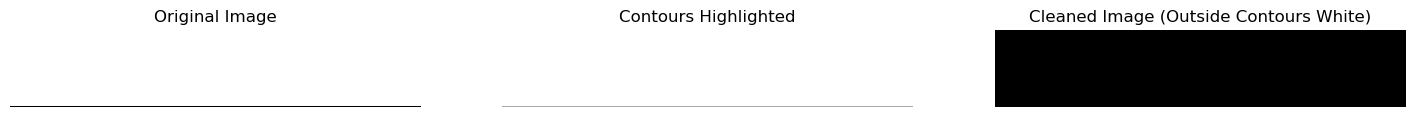

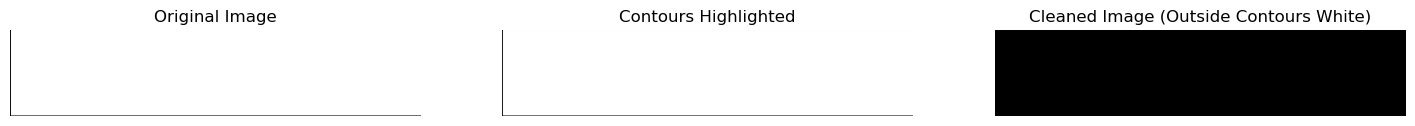

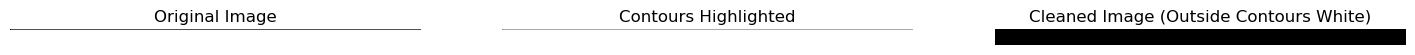

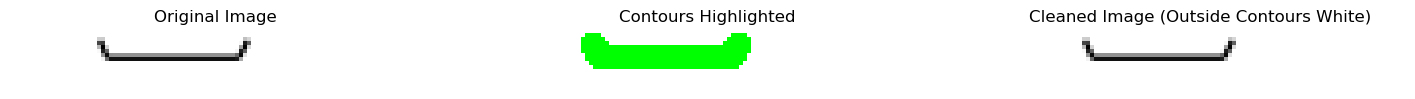

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Function to remove patches from an image and display the result
def remove_patches_and_display(image_path):
    # Load the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Check if the image was loaded correctly
    if image is None:
        print(f"Error: Unable to load the image '{image_path}'. Check the file path.")
        return

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(image, (5, 5), 0)

    # Apply adaptive thresholding to create a binary image
    binary_image = cv2.adaptiveThreshold(
        blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 31, 10
    )

    # Perform morphological operations to refine the binary image
    kernel = np.ones((3, 3), np.uint8)
    binary_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)

    # Find contours
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours based on area to remove small noise
    contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 100]

    # Create a mask filled with white (same size as the original image)
    mask = np.ones_like(binary_image) * 255

    # Draw contours on the mask and fill them with black
    cv2.drawContours(mask, contours, -1, 0, thickness=cv2.FILLED)

    # Create the cleaned image by turning everything outside the contours white
    cleaned_image = cv2.bitwise_or(image, mask)

    # Display the original image, contours, and cleaned image
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    # Original image
    ax[0].imshow(image, cmap='gray')
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    # Contours highlighted on the original image
    contour_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(contour_image, contours, -1, (0, 255, 0), thickness=2)
    ax[1].imshow(contour_image)
    ax[1].set_title('Contours Highlighted')
    ax[1].axis('off')

    # Cleaned image (everything outside the contours is white)
    ax[2].imshow(cleaned_image, cmap='gray')
    ax[2].set_title('Cleaned Image (Outside Contours White)')
    ax[2].axis('off')

    plt.show()

# Path to the folder containing the images
folder_path = "Shapes"

# Iterate over each image in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".png") or filename.endswith(".jpg"):
        # Construct the full path to the image
        image_path = os.path.join(folder_path, filename)

        # Remove patches and display the result
        remove_patches_and_display(image_path)


C:\Users\KIIT\AppData\Local\Temp\ipykernel_23892\257201398.py:66: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  corners = np.int0(corners)  # Convert to integer coordinates


Image: row_10.png, Number of corners detected: 3


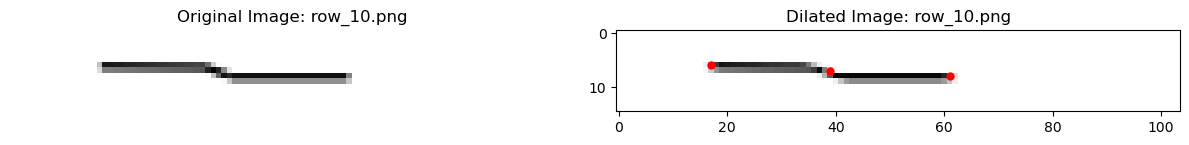

Image: row_11.png, Number of corners detected: 2


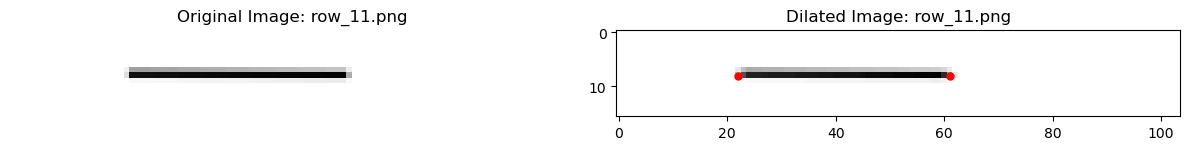

Image: row_12.png, Number of corners detected: 2


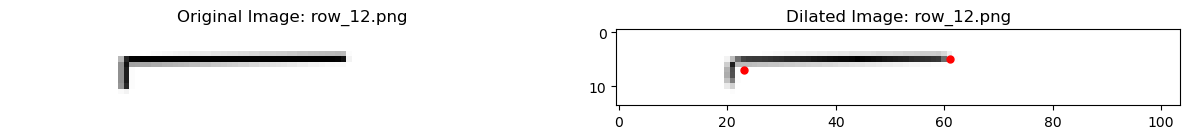

Image: row_13.png, Number of corners detected: 2


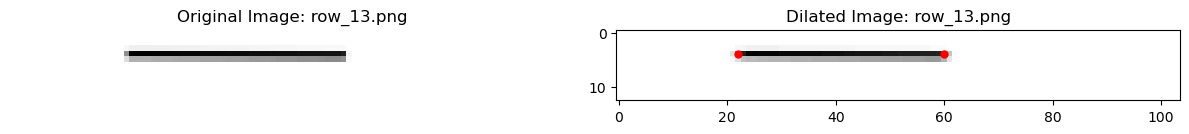

Image: row_14.png, Number of corners detected: 2


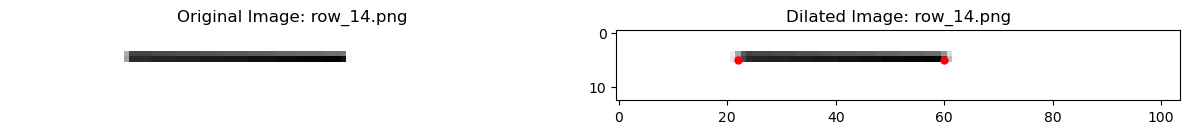

Image: row_15.png, Number of corners detected: 2


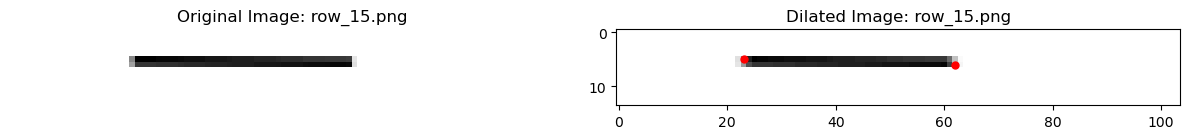

Image: row_16.png, Number of corners detected: 2


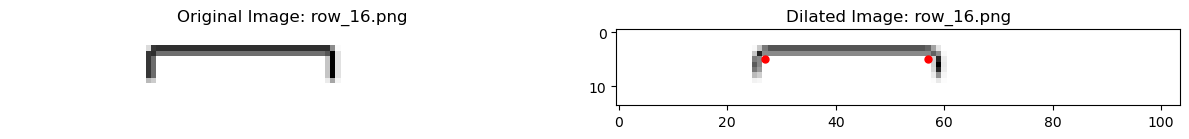

Image: row_17.png, Number of corners detected: 2


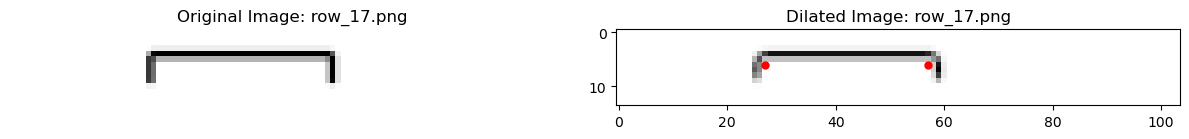

Image: row_18.png, Number of corners detected: 3


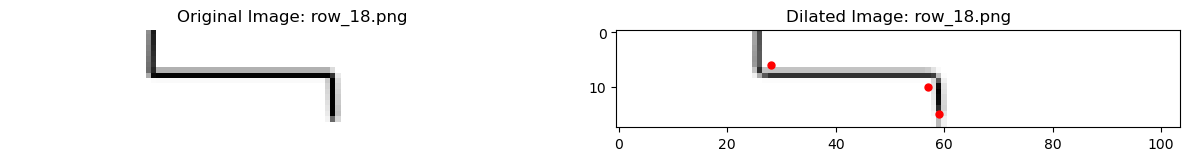

Image: row_19.png, Number of corners detected: 4


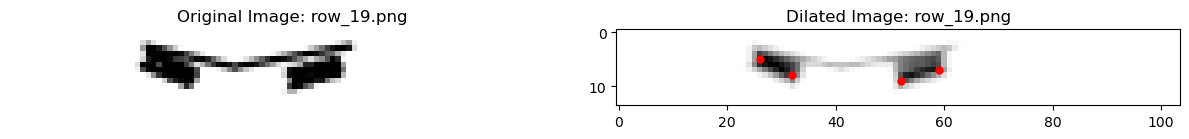

Image: row_20.png, Number of corners detected: 3


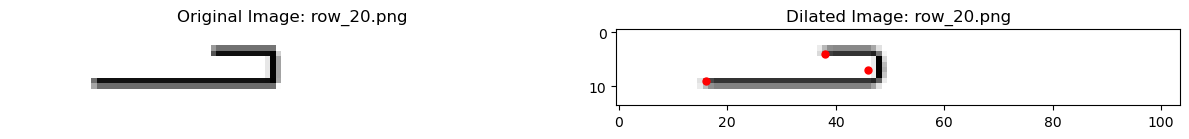

Image: row_21.png, Number of corners detected: 3


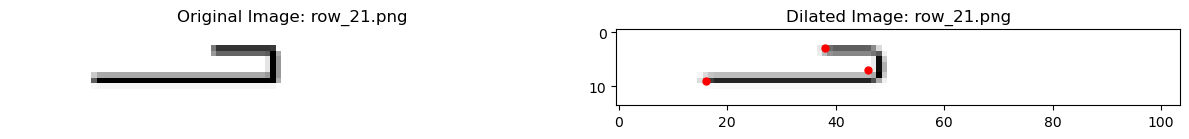

Image: row_22.png, Number of corners detected: 3


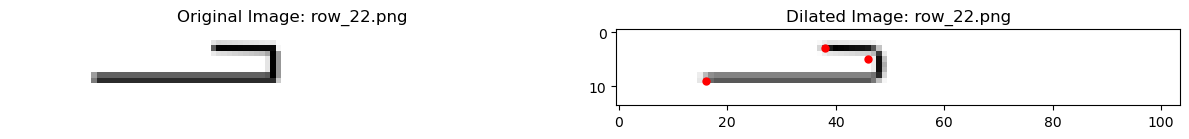

Image: row_23.png, Number of corners detected: 3


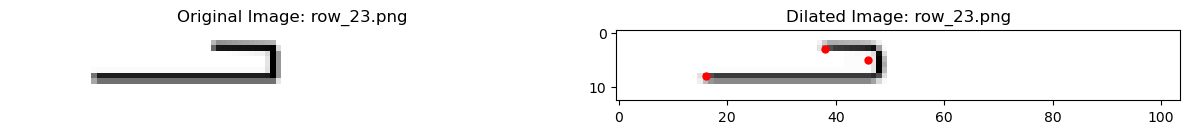

Image: row_24.png, Number of corners detected: 2


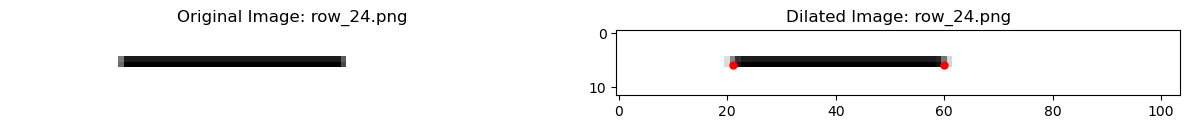

Image: row_25.png, Number of corners detected: 3


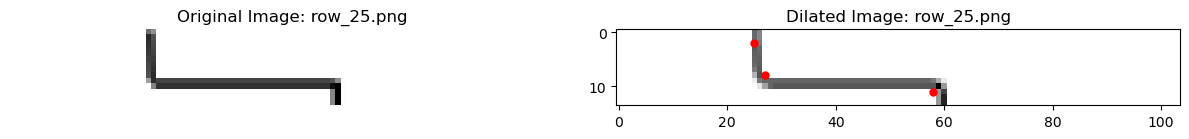

Image: row_26.png, Number of corners detected: 2


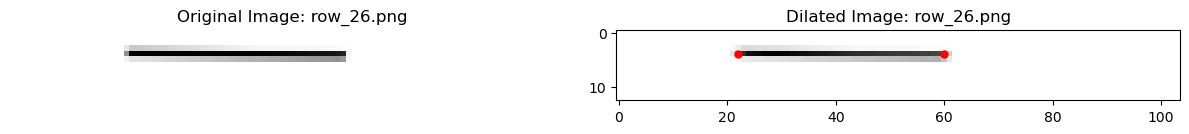

Image: row_27.png, Number of corners detected: 2


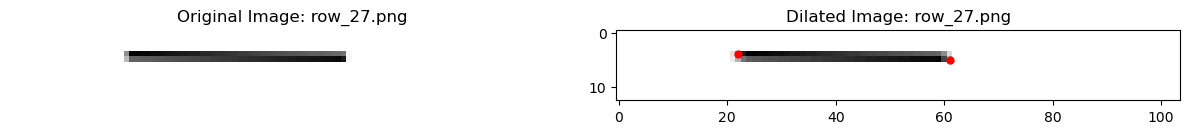

Image: row_28.png, Number of corners detected: 2


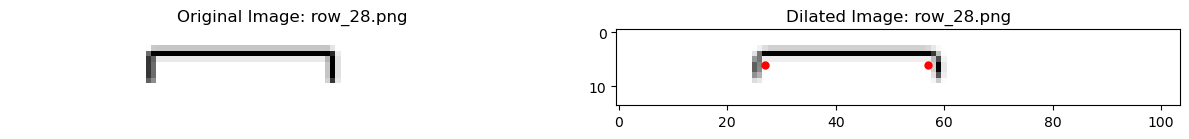

Image: row_29.png, Number of corners detected: 2


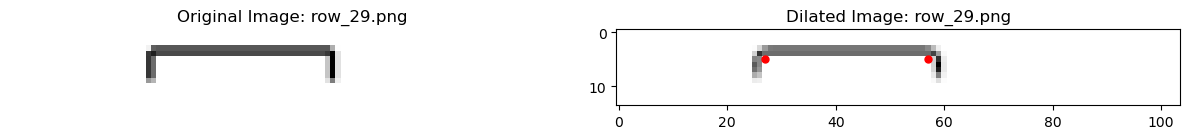

Image: row_3.png, No corners detected


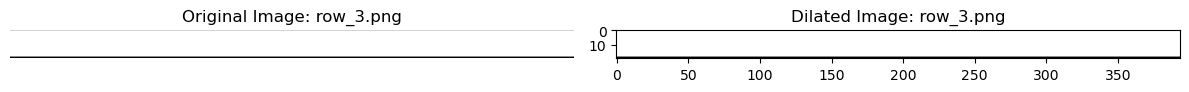

Image: row_30.png, Number of corners detected: 4


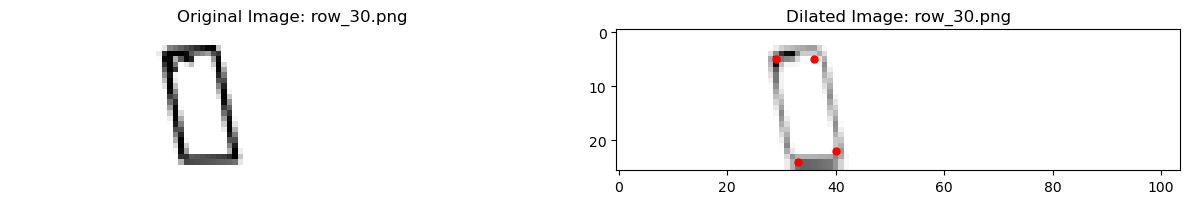

Image: row_31.png, Number of corners detected: 3


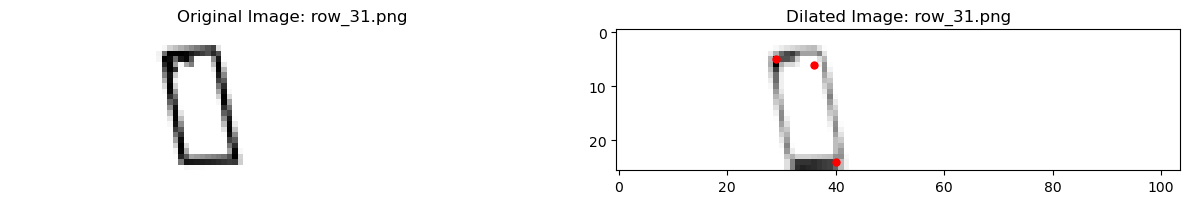

Image: row_32.png, Number of corners detected: 5


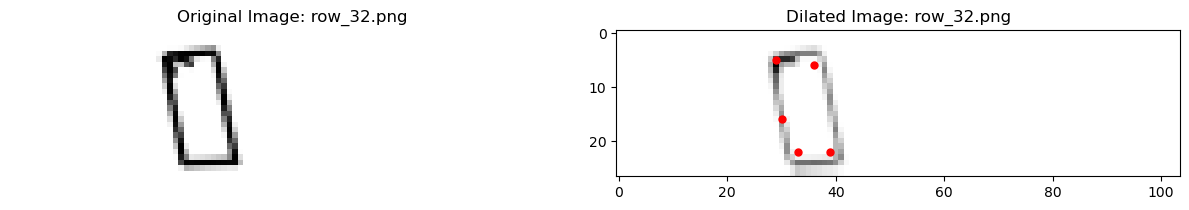

Image: row_33.png, Number of corners detected: 2


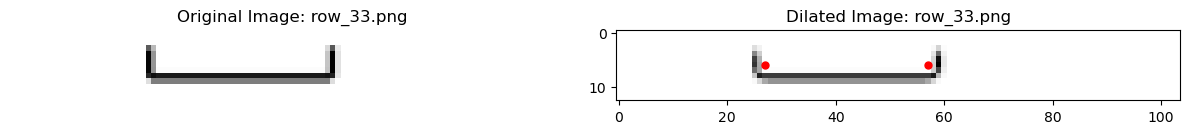

Image: row_34.png, Number of corners detected: 2


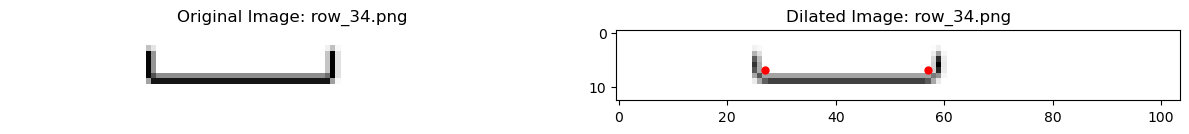

Image: row_35.png, Number of corners detected: 3


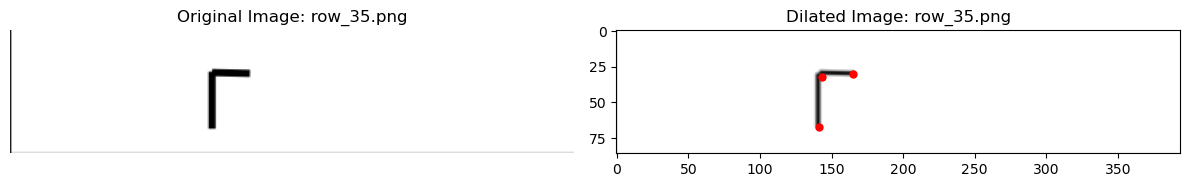

Image: row_36.png, Number of corners detected: 4


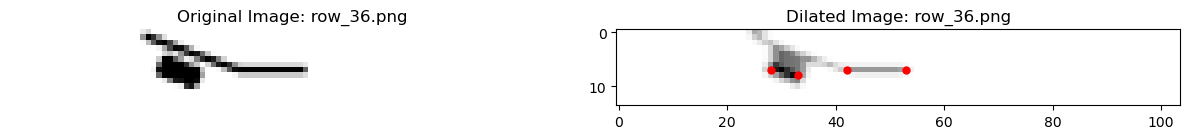

Image: row_37.png, Number of corners detected: 4


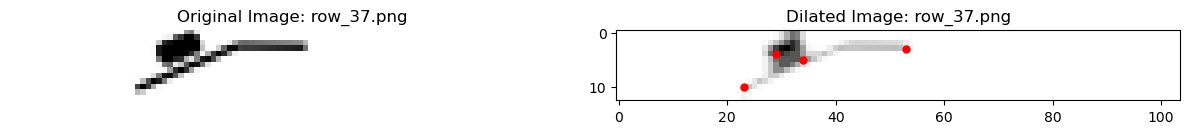

Image: row_38.png, Number of corners detected: 2


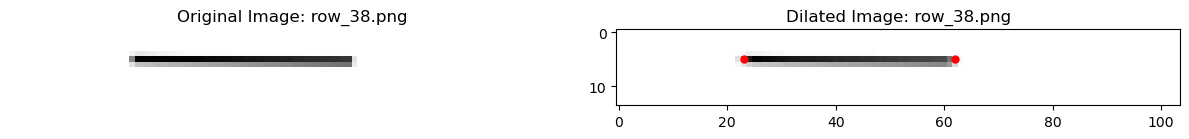

Image: row_39.png, Number of corners detected: 2


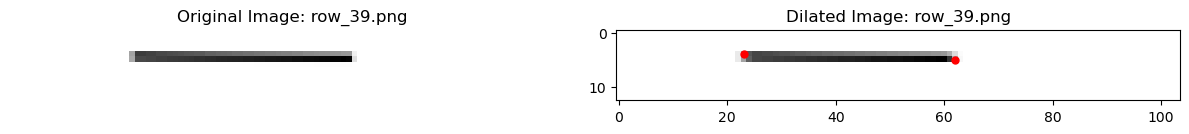

Image: row_4.png, No corners detected


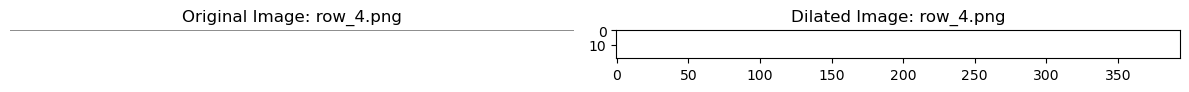

Image: row_40.png, Number of corners detected: 2


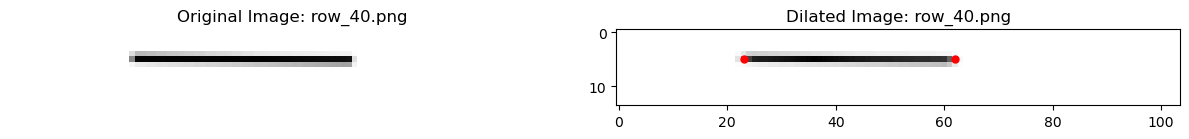

Image: row_41.png, Number of corners detected: 2


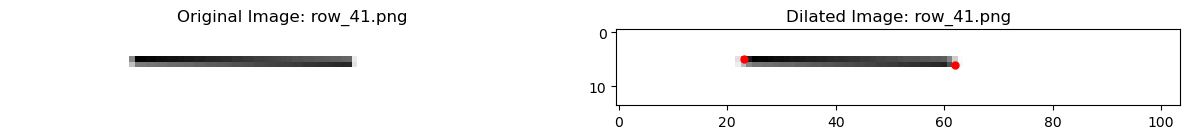

Image: row_42.png, Number of corners detected: 2


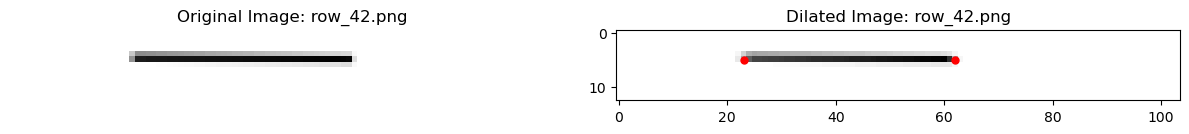

Image: row_43.png, Number of corners detected: 2


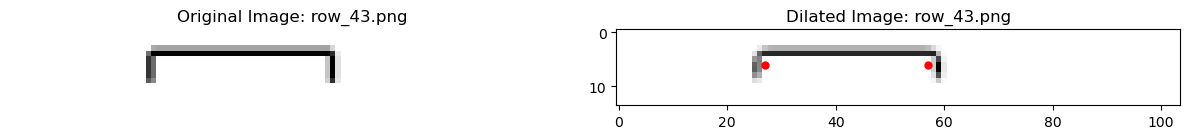

Image: row_44.png, Number of corners detected: 2


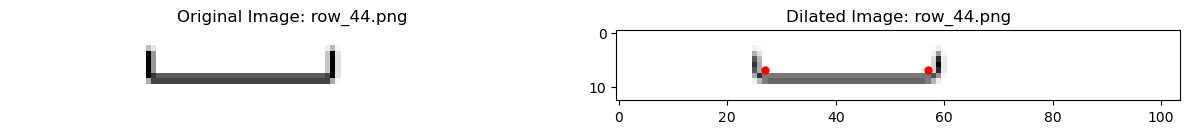

Image: row_45.png, Number of corners detected: 2


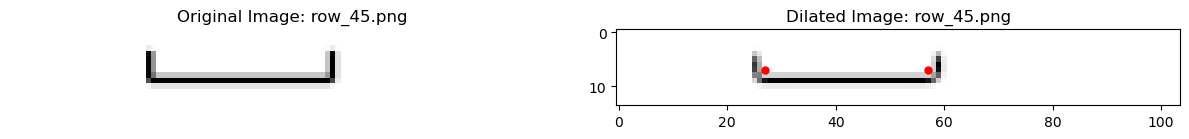

Image: row_46.png, Number of corners detected: 2


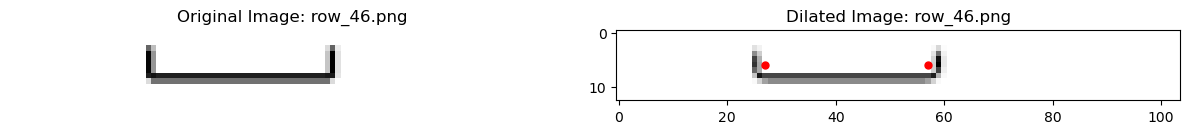

Image: row_47.png, Number of corners detected: 2


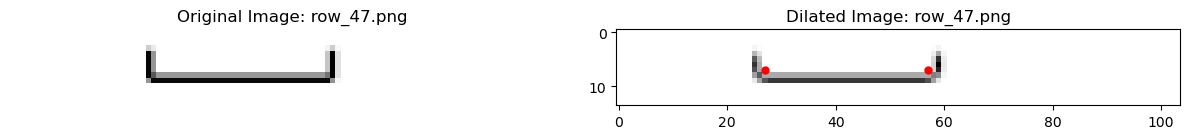

Image: row_5.png, Number of corners detected: 1


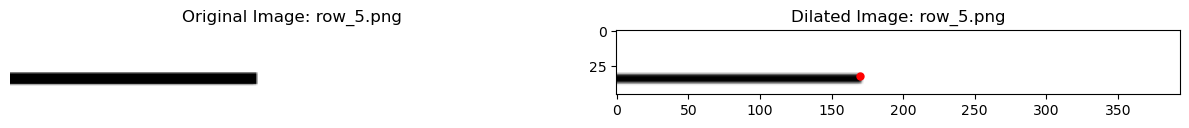

Image: row_6.png, No corners detected


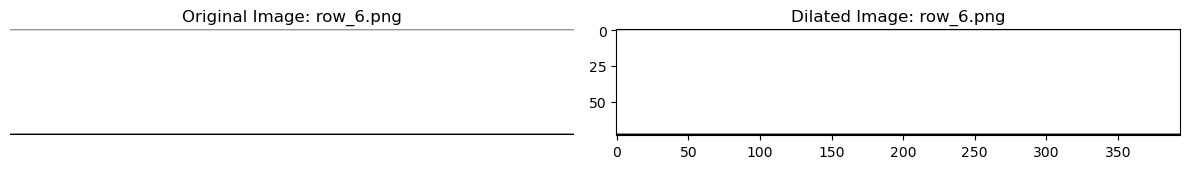

Image: row_7.png, Number of corners detected: 2


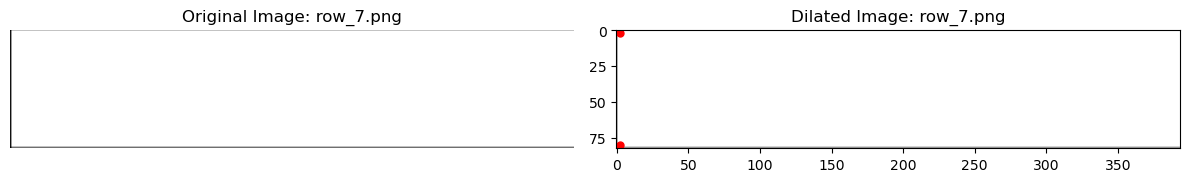

Image: row_8.png, No corners detected


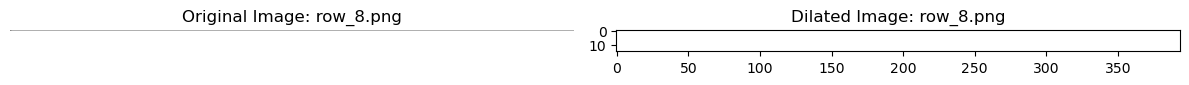

Image: row_9.png, Number of corners detected: 2


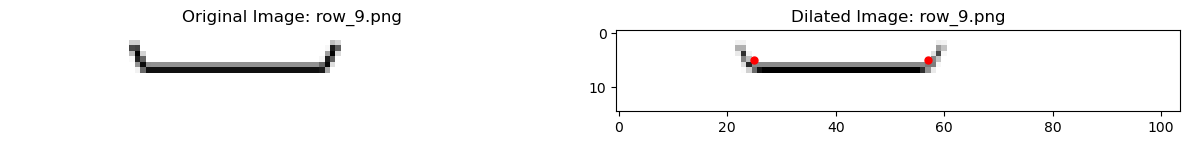

In [6]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# Folder path containing the cropped images
image_folder = "Shapes"

# Gaussian blur parameters
gaussian_ksize = (3, 3)
gaussian_sigma = 0  # Default sigma value for Gaussian blur

# Dilation kernel and iterations
dilation_kernel = np.ones((3, 3), np.uint8)
dilation_iterations = 2  # Number of dilation iterations

# Check if the folder exists
if not os.path.exists(image_folder):
    raise FileNotFoundError(f"Folder '{image_folder}' does not exist.")

# Get all valid image files in the folder
image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

# If no image files found, exit early
if not image_files:
    print("No valid image files found in the folder.")
else:
    # Loop through all image files in the folder
    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)

        try:
            # Read the image in grayscale
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            if image is None:
                print(f"Failed to read image: {image_file}")
                continue

            # Apply Gaussian blur for noise reduction
            blurred_img = cv2.GaussianBlur(image, gaussian_ksize, gaussian_sigma)

            # Apply dilation to enhance edges
            dilated_img = cv2.dilate(blurred_img, dilation_kernel, dilation_iterations)

            # Shi-Tomasi corner detection
            corners = cv2.goodFeaturesToTrack(
                dilated_img, maxCorners=300, qualityLevel=0.01, minDistance=5
            )

            # Visualize the image, corners, and bends
            plt.figure(figsize=(12, 6))

            # Plot the original image
            plt.subplot(1, 2, 1)
            plt.imshow(image, cmap='gray')
            plt.title(f"Original Image: {image_file}")
            plt.axis('off')

            # Plot the dilated image with corners
            plt.subplot(1, 2, 2)
            plt.imshow(dilated_img, cmap='gray')
            plt.title(f"Dilated Image: {image_file}")

            if corners is not None:
                corners = np.int0(corners)  # Convert to integer coordinates

                # Plot the corners on the image
                for corner in corners:
                    x, y = corner.ravel()  # Get x and y coordinates
                    plt.plot(x, y, 'ro', ms=5)  # Red dots for corners

                # Print the number of corners detected
                num_corners = len(corners)
                print(f"Image: {image_file}, Number of corners detected: {num_corners}")
            else:
                print(f"Image: {image_file}, No corners detected")

            # Show the plot
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"An error occurred while processing '{image_file}': {e}")


In [7]:
import os
import cv2
import numpy as np
import pandas as pd

# Folder path containing the cropped images
image_folder = "Shapes"

# Excel output file path
excel_output = "corner_detection_results.xlsx"

# Create an empty list to hold the data for the Excel sheet
data = []

# Gaussian blur parameters
gaussian_ksize = (3, 3)
gaussian_sigma = 0  # Default sigma value for Gaussian blur

# Dilation kernel and iterations
dilation_kernel = np.ones((3, 3), np.uint8)
dilation_iterations = 2  # Number of dilation iterations

# Check if the folder exists
if not os.path.exists(image_folder):
    raise FileNotFoundError(f"Folder '{image_folder}' does not exist.")

# Get all valid image files in the folder
image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

# If no image files found, exit early
if not image_files:
    print("No valid image files found in the folder.")
else:
    # Loop through all image files in the folder
    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)

        try:
            # Read the image in grayscale
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            if image is None:
                print(f"Failed to read image: {image_file}")
                continue

            # Apply Gaussian blur for noise reduction
            blurred_img = cv2.GaussianBlur(image, gaussian_ksize, gaussian_sigma)

            # Apply dilation to enhance edges
            dilated_img = cv2.dilate(blurred_img, dilation_kernel, dilation_iterations)

            # Shi-Tomasi corner detection
            corners = cv2.goodFeaturesToTrack(
                dilated_img, maxCorners=300, qualityLevel=0.01, minDistance=5
            )

            # Determine the number of corners
            if corners is not None:
                num_corners = len(corners)
                num_bends = max(0, num_corners - 2)  # Avoid negative values

                # Add the data to the list
                data.append({
                    'Image Name': image_file,
                    'Number of Corners': num_corners,
                    'Number of Bends': num_bends
                })

            else:
                # No corners detected, set 0 bends
                data.append({
                    'Image Name': image_file,
                    'Number of Corners': 0,
                    'Number of Bends': 0
                })

        except Exception as e:
            print(f"An error occurred while processing '{image_file}': {e}")

    # Create a DataFrame from the data list
    df = pd.DataFrame(data)

    # Save the DataFrame to an Excel file
    df.to_excel(excel_output, index=False)

    print(f"Results saved to '{excel_output}'")


Results saved to 'corner_detection_results.xlsx'
